In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
import numpy as np
import seaborn as sns

In [59]:
#to do:
#feature engineering on plays per year, to address imbalance in older albums having more plays
#add more data as time goes on
#see if we can impute TND score using other critic scores

In [60]:
#import data - make column names easier to work with
df = pd.read_csv("records.csv")
df.columns = (df.columns.str.strip().str.lower().str.replace(' ', '_')
              .str.replace('(', '').str.replace(')', '').str.replace('-', '_')
              .str.replace('.', '_'))
df = df.rename(columns = {
    'last_fm_scrobbles': 'lastfm'
})
df.lastfm = df.lastfm.str.replace(',', '')

In [61]:
#the reason the last instance is dropped is because it has a strange pattern
#it has all the attributes of an album that increases in price, but drops dramatically
#this was throwing the model off, so I got rid of it
df = df.drop([0])
df = df.replace('N/A', None)
df = df.drop(['artist', 'album'], axis=1)
df = df.drop(df.index[len(df)-1])

In [62]:
#calculate price change over time
price_difference = []
for i in df.index:
    change = df.median_discogs_price[i] - df.bought_for_roughly[i]
    price_difference.append(change)
df['price_difference'] = price_difference

In [63]:
#change categorical to numerical
#we can use labelencoder, since all this data is binary
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df['coloured_record'] = enc.fit_transform(df['coloured_record'])
df['limited'] = enc.fit_transform(df['limited'])
df['repress'] = enc.fit_transform(df['repress'])
df['version_first_hand'] = enc.fit_transform(df['version_first_hand'])
df['album_first_hand'] = enc.fit_transform(df['album_first_hand'])
df['personal_top_50'] = enc.fit_transform(df['personal_top_50'])

In [64]:
#this is a bit finicky, but we need to fill the nulls with zeros to change the column to int to calculate the mean
#impute the missing values with the mean, there are only 2
df.lastfm = df.lastfm.fillna(0)
df.lastfm = df.lastfm.astype(int)
df.lastfm = df.lastfm.replace(0, None)
m = df.lastfm.mean()
df.lastfm = df.lastfm.fillna(m)

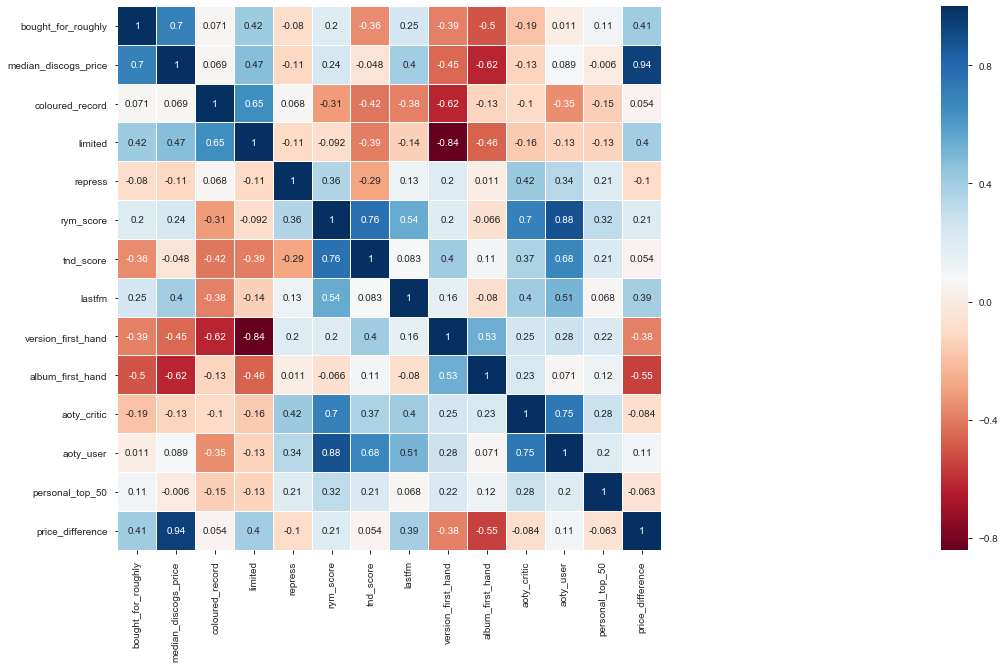

In [65]:
colormap = plt.cm.RdBu
plt.figure(figsize=(100, 10))
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', 
            annot=True,xticklabels=True, yticklabels=True)
plt.show()

In [66]:
#onehot encoding of genre - compare to price difference to see if there's any significance
#profile report shows there is little to none - so we don't need to use these encoded variables
df['genre'] = pd.Categorical(df['genre'])
dfDummies = pd.get_dummies(df['genre'], prefix='genre_')
df =  pd.concat([df, dfDummies], axis=1).drop(columns='genre')
dfTest = dfDummies.loc[:, dfDummies.columns.str.startswith('genre_')]
pd.options.mode.chained_assignment = None
dfTest['pricechange'] = df['price_difference']
#pp.ProfileReport(dfTest)

In [67]:
#turn this into a classification problem
#there isn't nearly enough data to accurately predict the value of a  price increase or decrease
#therefore, we can just predict if there has been a price increase, indicated by a 1
def binrow(row):
    if row['price_difference'] > 0:
        val = 1
    else:
        val = 0
    return val
df['binary_change'] = df.apply(binrow, axis=1)

In [68]:
#standardise numerical data
from sklearn.preprocessing import StandardScaler
st_data = df[['bought_for_roughly', 'median_discogs_price', 'rym_score', 'lastfm']]
st_data = st_data.astype(float)
standardised_Data = StandardScaler().fit_transform(st_data)
st_data = pd.DataFrame(standardised_Data, columns=[
    'st_bought', 'st_med', 'st_rym', 'st_scrob'])
df = df.join(st_data)
df = df.drop(df.index[len(df)-1])

In [69]:
# # normalise numerical data - this is pretty much useless in this case, just here for the hell of it
# from sklearn.preprocessing import MinMaxScaler
# norm_data = df[['bought_for_roughly', 'median_discogs_price', 'rym_score', 'lastfm']]
# norm_data = norm_data.astype(float)
# normalized_Data = MinMaxScaler().fit_transform(norm_data)
# norm_data = pd.DataFrame(normalized_Data, columns=[
#     'norm_bought', 'norm_med', 'norm_rym', 'norm_scrob'])
# df = df.join(norm_data)
# df = df.drop(df.index[len(df)-1])

In [70]:
#PCA can strengthen the model, just to make it a bit more accurate
from sklearn.decomposition import PCA
pc = df[['version_first_hand', 'album_first_hand', 'limited']]
pc = pc.fillna(method='ffill')
pc = StandardScaler().fit_transform(pc)
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(pc)
df['PC1'] = principalComponents

In [71]:
#we can use linear regression if we want, however there aren't nearly enough data points
#to accurately predict price, instead, it's better to make this a classification problem
from sklearn.model_selection import train_test_split
x = df[['PC1', 'album_first_hand', 'version_first_hand', 'limited', 'bought_for_roughly']]
y = df['price_difference']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(xtrain, ytrain)
ypred = regressor.predict(xtest)
df_pred = pd.DataFrame({'Actual': ytest, 'Predicted': ypred})

In [72]:
#random forests makes more sense over something like logistic regression here
#1 means price increase, 0 means price decrease or not changed
x = df[['PC1', 'album_first_hand', 'version_first_hand', 'limited', 'st_bought', 'st_scrob']]
y = df['binary_change']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.20)
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf = RandomForestClassifier(n_estimators=100)
clf.fit(xtrain, ytrain)
ypred = clf.predict(xtest)
print('RandomForest score:', metrics.accuracy_score(ytest, ypred))
df_pred = pd.DataFrame({'Actual': ytest, 'Predicted': ypred})
print(df_pred)

RandomForest score: 0.5384615384615384
    Actual  Predicted
29       0          0
44       0          1
3        1          1
49       0          1
34       0          1
10       1          0
14       1          1
54       0          0
28       1          1
52       0          0
20       1          0
1        1          1
13       1          0


In [73]:
#since it's a small dataset, we can perform cross validation
#makes sure results are consistent - not due to a high amount of 1s or 0s in the test data
from sklearn.model_selection import cross_val_score
clf.fit(xtrain, ytrain)
scores = cross_val_score(clf, x, y, cv=5)
print(scores)

[0.69230769 0.69230769 0.69230769 0.66666667 0.58333333]


In [74]:
#confusion matrix to show false/true positives/negatives in our predictions
confusion = pd.crosstab(ytest, ypred, rownames=['Actual'], colnames=['Predicted'])
print(confusion)

Predicted  0  1
Actual         
0          3  3
1          3  4
